In [1]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from torch.utils import data
import xarray as xr
import cfr
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Data preprocessing

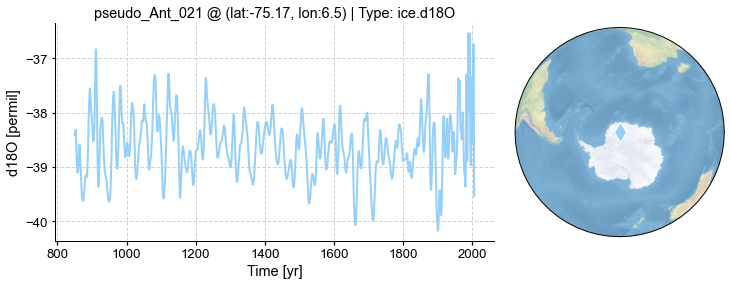

In [3]:
pdb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.ice.d18O.pkl')
fig, ax = pdb.records['pseudo_Ant_021'].plot()

In [6]:
dirpath = './data'

tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
psl = cfr.ClimateField().load_nc(os.path.join(dirpath, 'psl_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
d18O = cfr.ClimateField().load_nc(os.path.join(dirpath, 'd18O_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

In [7]:
tas_ann = tas.annualize()
pr_ann = pr.annualize()
psl_ann = psl.annualize()
d18O_ann = d18O.annualize()

In [8]:
pobj = pdb.records['pseudo_Ant_021']
pobj.del_clim()
pobj.get_clim(tas_ann, tag='obs')
pobj.get_clim(pr_ann, tag='obs')
pobj.get_clim(psl_ann, tag='obs')
pobj.get_clim(d18O_ann, tag='obs')

In [9]:
features, scaler_f = cfr.ml.mk_tensors([
    pobj.clim['obs_tas'].da.values,
    pobj.clim['obs_pr'].da.values,
    pobj.clim['obs_psl'].da.values,
    pobj.clim['obs_d18O'].da.values,
])
features.shape

torch.Size([1156, 4])

In [10]:
labels, scaler_l = cfr.ml.mk_tensors([pobj.value])
labels.shape

torch.Size([1156, 1])

In [11]:
features_exp = cfr.ml.sliding_tensor(features)
labels_exp = cfr.ml.sliding_tensor(labels)
print(features_exp.shape)
print(labels_exp.shape)

torch.Size([1154, 3, 4])
torch.Size([1154, 3, 1])


In [12]:
data_dict = cfr.ml.split_data(features_exp, labels_exp, batch_size=5)
train_loader = data_dict['train_loader']
valid_f, valid_l = data_dict['valid_f'], data_dict['valid_l']
test_f, test_l = data_dict['test_f'], data_dict['test_l']

## GRU

In [30]:
ne = 50
lr = 0.001

res = cfr.ml.train_model(
    train_loader, valid_f, valid_l, lr=lr, model_type='GRU',
    max_epochs=ne, save_path=f'./data/model/optim_gru_{pobj.pid}.pt',
)

device: cpu
Starting training of "GRU" model.
Epoch 1/50 - Train loss: 0.023856389086585546, Valid loss: 0.01364944502711296
Epoch 2/50 - Train loss: 0.019763043912066874, Valid loss: 0.013430122286081314
Epoch 3/50 - Train loss: 0.01741075945302736, Valid loss: 0.015796681866049767
Epoch 4/50 - Train loss: 0.017045611195077283, Valid loss: 0.013666979968547821
Epoch 5/50 - Train loss: 0.016005085243006655, Valid loss: 0.012466706335544586
Epoch 6/50 - Train loss: 0.017467643090429297, Valid loss: 0.01532402541488409
Epoch 7/50 - Train loss: 0.01639132855453299, Valid loss: 0.012939873151481152
Epoch 8/50 - Train loss: 0.016581035923529955, Valid loss: 0.015622413717210293
Epoch 9/50 - Train loss: 0.016992393539428875, Valid loss: 0.014499170705676079
Epoch 10/50 - Train loss: 0.01641213260607902, Valid loss: 0.012190142646431923
Epoch 11/50 - Train loss: 0.01619243625537965, Valid loss: 0.012769082561135292
Epoch 12/50 - Train loss: 0.016240976857142927, Valid loss: 0.0146519141271710

In [31]:
model, train_loss, valid_loss, optim_epoch = torch.load('./data/model/optim_gru_pseudo_Ant_021.pt')

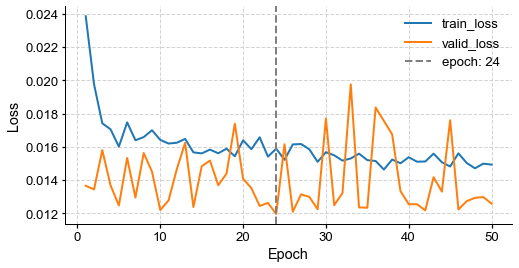

In [32]:
fig, ax = cfr.visual.plot_ml_loss(train_loss, valid_loss, optim_epoch=optim_epoch)

device: cpu


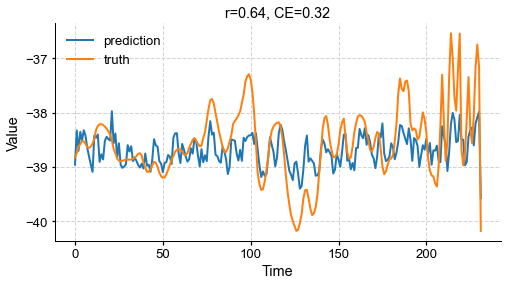

In [33]:
res_dict = cfr.ml.eval_model(model, test_f, test_l, scaler_l, model_type='GRU')
fig, ax = cfr.visual.plot_ml_predict(res_dict)

## LSTM

In [22]:
ne = 50
lr = 0.001

res = cfr.ml.train_model(
    train_loader, valid_f, valid_l, lr=lr, model_type='LSTM',
    max_epochs=ne, save_path=f'./data/model/optim_lstm_{pobj.pid}.pt',
)

device: cpu
Starting training of "LSTM" model.
Epoch 1/50 - Train loss: 0.03397509913496754, Valid loss: 0.021477384492754936
Epoch 2/50 - Train loss: 0.02203206376567402, Valid loss: 0.014282737858593464
Epoch 3/50 - Train loss: 0.019830650747821168, Valid loss: 0.014417596161365509
Epoch 4/50 - Train loss: 0.018112665053247812, Valid loss: 0.018442170694470406
Epoch 5/50 - Train loss: 0.017570603465108012, Valid loss: 0.016183212399482727
Epoch 6/50 - Train loss: 0.017527790036578866, Valid loss: 0.012968597933650017
Epoch 7/50 - Train loss: 0.016915959275692054, Valid loss: 0.014010224491357803
Epoch 8/50 - Train loss: 0.017118642673544262, Valid loss: 0.016784392297267914
Epoch 9/50 - Train loss: 0.017283424809305132, Valid loss: 0.012965942732989788
Epoch 10/50 - Train loss: 0.016791108661614682, Valid loss: 0.013499748893082142
Epoch 11/50 - Train loss: 0.016613544534345197, Valid loss: 0.014888381585478783
Epoch 12/50 - Train loss: 0.01671397649899017, Valid loss: 0.013373868539

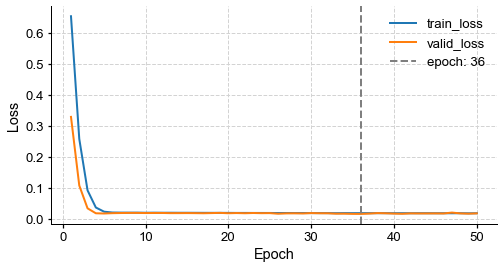

In [23]:
fig, ax = cfr.visual.plot_ml_loss(train_loss, valid_loss, optim_epoch=optim_epoch)

In [25]:
model, train_loss, valid_loss, optim_epoch = torch.load('./data/model/optim_lstm_pseudo_Ant_021.pt')

device: cpu


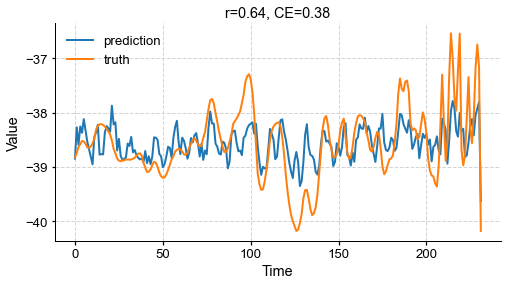

In [26]:
res_dict = cfr.ml.eval_model(model, test_f, test_l, scaler_l, model_type='LSTM')
fig, ax = cfr.visual.plot_ml_predict(res_dict)

## Linear regression

In [27]:
ne = 50
lr = 0.001

res = cfr.ml.train_model(
    train_loader, valid_f, valid_l, lr=lr, model_type='Linear',
    max_epochs=ne, save_path=f'./data/model/optim_linreg_{pobj.pid}.pt',
)

device: cpu
Starting training of "Linear" model.
Epoch 1/50 - Train loss: 0.29576158420979115, Valid loss: 0.11333391070365906
Epoch 2/50 - Train loss: 0.08566113044102878, Valid loss: 0.030788922682404518
Epoch 3/50 - Train loss: 0.031833704372031105, Valid loss: 0.02016119286417961
Epoch 4/50 - Train loss: 0.023589946031384847, Valid loss: 0.021035943180322647
Epoch 5/50 - Train loss: 0.02261698452765932, Valid loss: 0.021586952731013298
Epoch 6/50 - Train loss: 0.02244708625147578, Valid loss: 0.02117677591741085
Epoch 7/50 - Train loss: 0.02213452978943731, Valid loss: 0.021212344989180565
Epoch 8/50 - Train loss: 0.022070253934319793, Valid loss: 0.021067237481474876
Epoch 9/50 - Train loss: 0.021761985861804282, Valid loss: 0.020483097061514854
Epoch 10/50 - Train loss: 0.02162755168704451, Valid loss: 0.020591264590620995
Epoch 11/50 - Train loss: 0.02140739445483474, Valid loss: 0.020161602646112442
Epoch 12/50 - Train loss: 0.02118831375559819, Valid loss: 0.019794704392552376

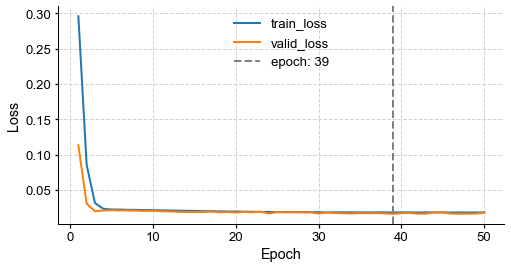

In [28]:
train_loss, valid_loss, optim_epoch = res['train_loss'], res['valid_loss'], res['optim_epoch']
fig, ax = cfr.visual.plot_ml_loss(train_loss, valid_loss, optim_epoch=optim_epoch)

device: cpu


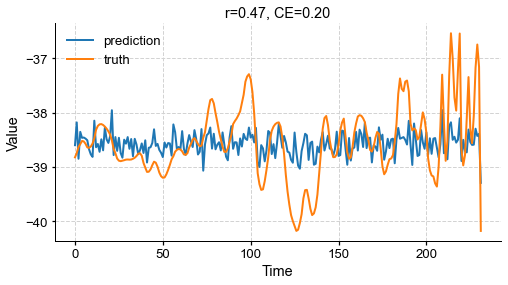

In [29]:
res_dict = cfr.ml.eval_model(res['optim_model'], test_f, test_l, scaler_l, model_type='Linear')
fig, ax = cfr.visual.plot_ml_predict(res_dict)